# Predicting the Effects of COVID-19 Restrictions Using Historical Traffic Data
## By: Andrew LaFortune, May 6th 2022

### Scenario
Two years into the COVID-19 pandemic and starting to see the light at the end of the tunnel, the Minnesota Governor's Office has started to reflect on the actions they took early on in the pandemic. They have asked LFDS (LaFortune Data Solutions) to find a way to numerically evaluate the effectiveness of stay-at-home and reopening policies not just in terms of the number of COVID cases, but in other less obvious numbers that might be found in other datasets online. These other data points are up to LFDS to find and examine. The final product to be delivered is a model that might be used in future pandemic situations to determine which restrictions and relaxations on businesses to deploy and in what time frame to minimize the spread of disease. 

### Approach
The primary dataset that will bridge the gap between the Governor's policies and COVID-19 cases is the Minnesota Department of Transportation's (MNDOT) Automatic Traffic Recorder (ATR) and Weigh in Motion (WIM) [Hourly Volume Data](http://www.dot.state.mn.us/traffic/data/data-products.html). Some work has already been done with this data to visualize the percent difference in traffic volume from the average daily traffic volume across all days 2016-2019 ([PDF Download](https://edocs-public.dot.state.mn.us/edocs_public/DMResultSet/download?docId=12227832)). LFDS believes this is a good first step, but would like to produce a model that adjusts for nuances in typical daily or seasonal traffic patterns. This goal is summarized by Deliverable 1:
> Deliverable 1: Graph Daily Volume Change for each MNDOT District and statewide compared to daily baseline.
__Note:__ The 2016 volume data is no longer available, so the baseline to compare will be from 2017-2019

The goal of this report is to see how key policy decisions affected COVID cases. To see this, LFDS gathered several COVID case count datasets from the [New York Times COVID-19 Data GitHub](https://github.com/nytimes/covid-19-data). These datasets provide counts from January 21st, 2020 to the present day (May 3rd at the latest update of this notebook) at country-wide, state-wide, and county-wide levels. Compiling these into graphs for comparison with the traffic volume data will be the goal of Deliverable 2:
> Deliverable 2: Graph Daily COVID-19 case and death counts in Minnesota.

These graphs will likely show some clear trends in traffic and COVID cases that may have some visual relation and indicate when major policy changes occured. To verify these instances and work towards a model for gauging effectiveness of policy changes, the events from BallotPedia's [Documenting Minnesota's path to recovery from the coronavirus (COVID-19) pandemic, 2020-2021"](https://ballotpedia.org/Documenting_Minnesota%27s_path_to_recovery_from_the_coronavirus_(COVID-19)_pandemic,_2020-2021) article have been compiled into a spreadsheet with dates and classifications for each notable event. The events can be added to the plots of traffic volume and COVID-19 cases to paint a clearer picture of what happened immediately following policy changes for Deliverable 3:
> Deliverable 3: Deliverable 1 and 2 graphs with vertical lines indicating when policy changes went into effect.

Deliverables 1, 2, and 3 will give some idea of __what happened__. The last piece of this project is to condense that data into a useful model that can be used to predict __what will happen__ if similar restriction/relaxation measures are taken in a future pandemic situation. LFDS has decided that the best model for the job is a Time Series Forecasing model that takes as inputs the proportion of expected traffic volume for 30 days prior to an event predict the target variable of daily traffic volume percent difference from baseline for next 10 days.

Deliverable 4 will consist of testing the Facebook Prophet time series prediction model for this task with the goal of minimizing the error between model prediction and real value for traffic volume percent difference. This will include the test scenarios:
- a baseline prediction on a non-COVID year
- a prediction immediately following each type of COVID policy change

Based on the results of these scenarios, a recommendation to use Facebook's Prophet model or to look for other options:
> Deliverable 4: A recommendation of Time Series Forecasting model, or a recommendation to look for other prediction methods.

In [0]:
%pip install pystan==2.19.1.1
%pip install fbprophet==0.7

Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.window import Window
import pyspark.pandas as ps
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from fbprophet import Prophet
import pandas as pd

In [0]:
county_wim = sqlContext.table("county_wim_2017_2022")
state_wim = sqlContext.table("state_wim_2017_2022")
mn_county_covid = sqlContext.table("mn_county_covid_2020_2022")
average_county_covid = sqlContext.table("average_county_covid_2020_2022")
us_covid = sqlContext.table("total_us_covid_2020_2022")
state_covid = sqlContext.table("total_state_covid_2020_2022")
mn_timeline = sqlContext.table("mn_covid_timeline")

In [0]:
print(county_wim.columns)

['county', 'district', 'station_id', 'date', 'totalVolume']


In [0]:
wim_daily_district = county_wim.groupBy("date","district").agg(F.sum(F.col("totalVolume")).alias("totalVolume"))
wim_daily_district.display()

date,district,totalVolume
2019-02-18,2,13489
2020-04-17,2,10435
2019-10-25,2,11888
2020-05-18,2,8321
2019-02-20,2,11748
2019-04-03,6,131659
2019-01-17,6,125497
2021-10-21,6,173476
2019-08-09,6,133610
2021-05-26,6,149984


In [0]:
wim_daily_district.agg(F.min("date"),F.max("date")).show()

+----------+----------+
| min(date)| max(date)|
+----------+----------+
|2017-01-01|2022-02-28|
+----------+----------+



In [0]:
wim_iso_daily = wim_daily_district.withColumn("year",F.year("date")) \
                                  .withColumn("week",F.format_string("%02d",F.weekofyear("date"))) \
                                  .withColumn("weekday",F.format_string("%02d",F.dayofweek("date")))
pre_covid = wim_iso_daily.filter(F.col("year") < 2020) \
                      .groupBy("week","weekday","district") \
                      .agg(F.mean("totalVolume").alias("Pre-COVID Average"))
pre_post_covid_comparison = wim_iso_daily.filter(F.col("year") >= 2020).join(pre_covid,["week","weekday","district"],"left") \
                                         .withColumn("prop",F.col("totalVolume") / F.col("Pre-COVID Average")) \
                                         .select("date","district","totalVolume","Pre-COVID Average","prop")
pre_post_covid_comparison.limit(10).show()

+----------+--------+-----------+------------------+-------------------+
|      date|district|totalVolume| Pre-COVID Average|               prop|
+----------+--------+-----------+------------------+-------------------+
|2020-04-17|       2|      10435|           12736.0| 0.8193310301507538|
|2020-05-18|       2|       8321|10473.666666666666| 0.7944686674517043|
|2021-10-21|       6|     173476| 99217.33333333333| 1.7484444922258209|
|2021-05-26|       6|     149984|           90085.0| 1.6649164677804296|
|2021-06-25|   Metro|     823087|         1674975.0|  0.491402558247138|
|2020-10-16|   Metro|     278658|1600039.3333333333|0.17415696864118757|
|2021-01-13|   Metro|     799923|         1347665.0| 0.5935621983207993|
|2021-08-05|   Metro|     672967|1567244.3333333333| 0.4293950762410371|
|2021-01-20|   Metro|     489164|1428978.3333333333|0.34231729662334515|
|2020-07-15|       8|      12657|11264.666666666666| 1.1236018228087827|
+----------+--------+-----------+------------------

In [0]:
wim_daily_state = state_wim.groupBy("date").agg(F.sum(F.col("totalVolume")).alias("totalVolume"))
wim_iso_daily_state = wim_daily_state.withColumn("year",F.year("date")) \
                                  .withColumn("week",F.format_string("%02d",F.weekofyear("date"))) \
                                  .withColumn("weekday",F.format_string("%02d",F.dayofweek("date")))
pre_covid_state = wim_iso_daily_state.filter(F.col("year") < 2020) \
                                      .groupBy("week","weekday") \
                                      .agg(F.mean("totalVolume").alias("Pre-COVID Average"))
pre_post_covid_comparison_state = wim_iso_daily_state.filter(F.col("year") >= 2020).join(pre_covid_state,["week","weekday"],"left") \
                                                     .withColumn("prop",F.col("totalVolume") / F.col("Pre-COVID Average")) \
                                                     .select("date","totalVolume","Pre-COVID Average","prop")
pre_post_covid_comparison_state.limit(10).show()

+----------+-----------+------------------+-------------------+
|      date|totalVolume| Pre-COVID Average|               prop|
+----------+-----------+------------------+-------------------+
|2020-04-13|     391162|1730735.6666666667|0.22600909401339353|
|2020-02-26|     704910|1718653.6666666667|0.41015244296843983|
|2021-11-03|    1049892|1764444.6666666667| 0.5950268772006452|
|2020-06-24|     426759|         1925925.0|0.22158651037812999|
|2020-09-12|     557259|1607567.6666666667|  0.346647305463347|
|2021-04-06|    1204418|1581168.3333333333| 0.7617266135484204|
|2020-11-12|     530563|         1717640.0| 0.3088906872220023|
|2020-06-08|     610815|         1846337.0| 0.3308253043729287|
|2020-06-22|     540643|1881227.6666666667|0.28738839513133535|
|2021-02-18|     995648|1814540.3333333333| 0.5487053562325519|
+----------+-----------+------------------+-------------------+



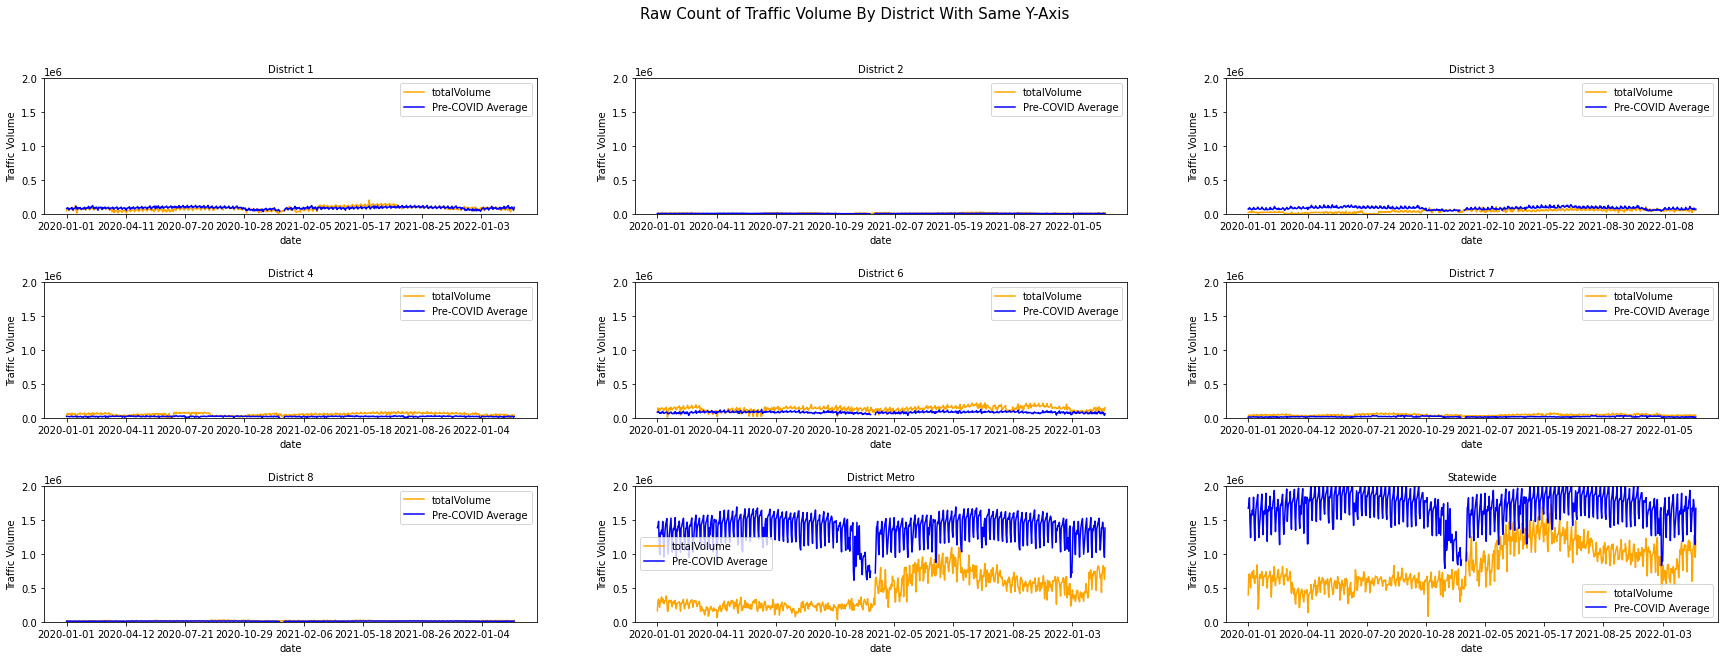

In [0]:
for_plot = pre_post_covid_comparison.toPandas()
for_plot = for_plot.sort_values("date")

for_plot_state = pre_post_covid_comparison_state.toPandas()
for_plot_state = for_plot_state.sort_values("date")

district_groups = for_plot.groupby("district")

#plot setup
plt.rcParams["figure.figsize"] = (30,10)
fig, axes = plt.subplots(3,3)

plt.subplots_adjust(hspace=0.5)
plt.suptitle('Raw Count of Traffic Volume By District With Same Y-Axis',fontsize=15)
plt.setp(axes, ylim=(0,2000000))
axe = axes.ravel()

#plot for each district
index = 0
for district,_ in district_groups:
    df = district_groups.get_group(district)
    
    cax = axe[index]
    cax.set(ylabel='Traffic Volume')
    cax.set_title('District '+str(district),fontsize=10)
    df.plot.line(x='date',y='totalVolume',ax=cax,color='orange')
    df.plot.line(x='date',y='Pre-COVID Average',ax=cax,color='blue')
    index += 1

#plot state volume
cax = axe[index]
cax.set(ylabel='Traffic Volume')
cax.set_title('Statewide',fontsize=10)
for_plot_state.plot.line(x='date',y='totalVolume',ax=cax,color='orange')    
for_plot_state.plot.line(x='date',y='Pre-COVID Average',ax=cax,color='blue')    
    
plt.show()

The graphs with scales for traffic volume from 0 to 2 million represent what would be expected: the Metro distric makes up a majority of the traffic throughout the state. Looking at traffic by district may show how closely each district adhered to distancing policies.

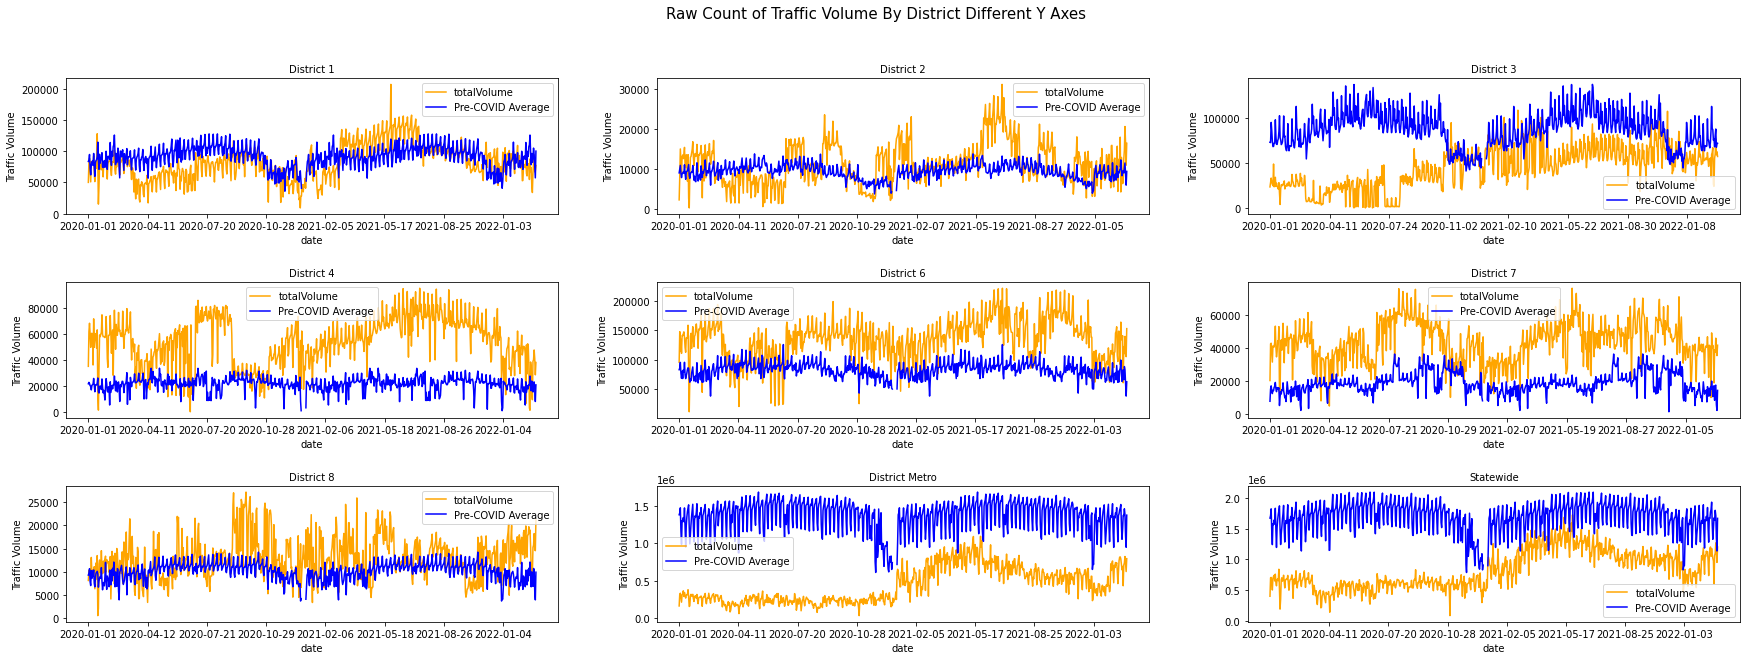

In [0]:
#plot setup
plt.rcParams["figure.figsize"] = (30,10)

fig, axes = plt.subplots(3,3)
plt.subplots_adjust(hspace=0.5)
plt.suptitle('Raw Count of Traffic Volume By District Different Y Axes',fontsize=15)
# plt.setp(axes, ylim=(0,2000000))
axe = axes.ravel()

#plot for each district
index = 0
for district,_ in district_groups:
    df = district_groups.get_group(district)
    
    cax = axe[index]
    cax.set(ylabel='Traffic Volume')
    cax.set_title('District '+str(district),fontsize=10)
    df.plot.line(x='date',y='totalVolume',ax=cax,color='orange')
    df.plot.line(x='date',y='Pre-COVID Average',ax=cax,color='blue')
    index += 1

#plot state volume
cax = axe[index]
cax.set(ylabel='Traffic Volume')
cax.set_title('Statewide',fontsize=10)
for_plot_state.plot.line(x='date',y='totalVolume',ax=cax,color='orange')    
for_plot_state.plot.line(x='date',y='Pre-COVID Average',ax=cax,color='blue')    
    
plt.show()

These graphs show that total traffic volume changed frequently throughout the COVID years, but the graph for Pre-COVID average traffic also has a lot of variation. To get a better idea of relative trends the total volume during COVID can be divided by the average value before COVID to yield a percentage of the expected traffic during COVID.

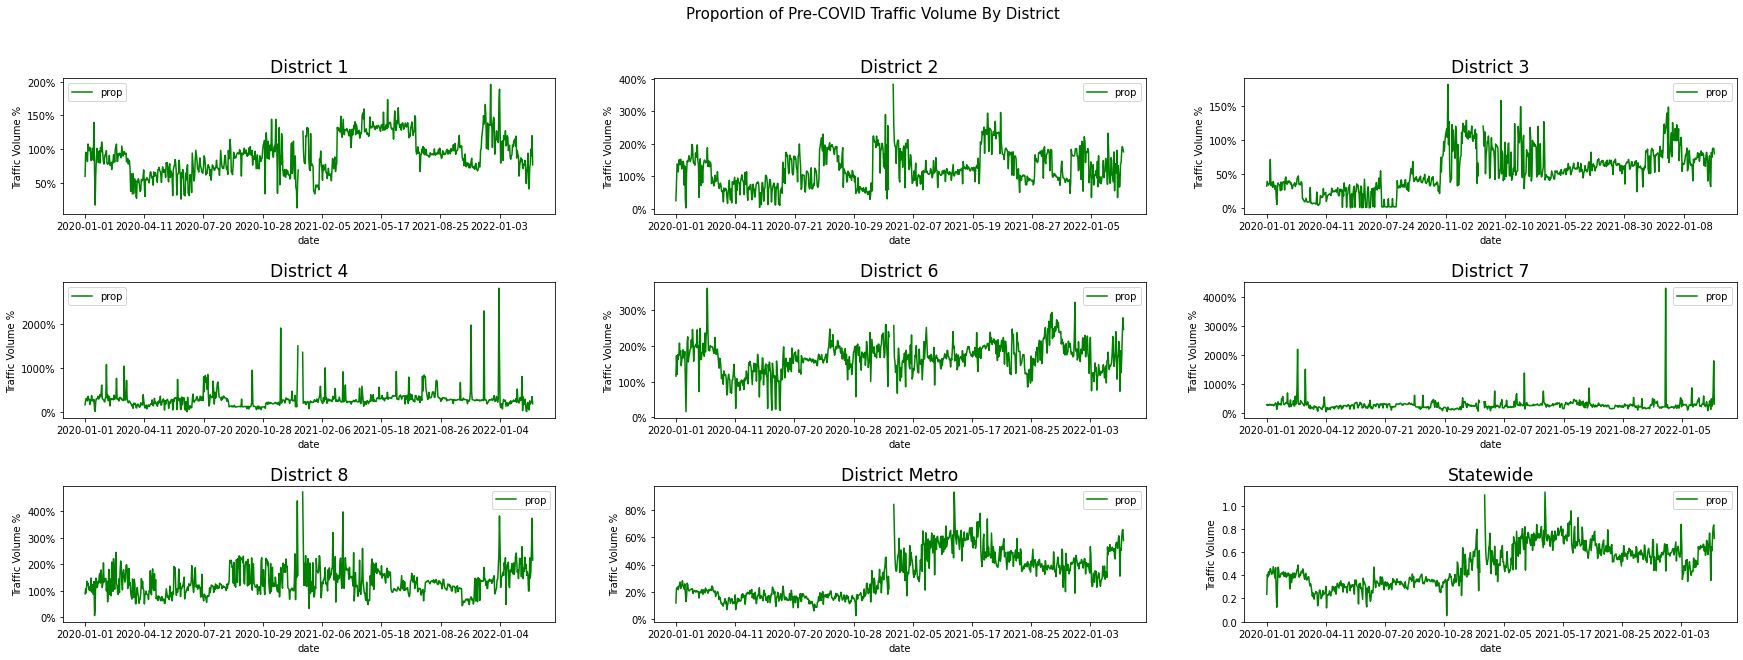

In [0]:
#plot setup
plt.rcParams["figure.figsize"] = (30,10)

fig, axes = plt.subplots(3,3)
plt.subplots_adjust(hspace=0.5)
plt.suptitle('Proportion of Pre-COVID Traffic Volume By District',fontsize=15)
axe = axes.ravel()

index=0
for district,_ in district_groups:
    df = district_groups.get_group(district)
    
    cax = axe[index]
    cax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    cax.set(ylabel='Traffic Volume %')
    cax.set_title('District '+str(district),fontsize='xx-large')
    df.plot.line(x='date',y='prop',ax=cax,color='green')
    index += 1

cax = axe[index]
cax.set(ylabel='Traffic Volume')
cax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
cax.set_title('Statewide',fontsize='xx-large')
for_plot_state.plot.line(x='date',y='prop',ax=cax,color='green')    
    
plt.show()

These graphs give a clearer picture of what happened during COVID. District 1 (Northeast MN), District 6 (Southwest MN), and the Metro district all have some clear trends of sharp dips in traffic volume early in the pandemic followed by gradual increases in traffic and some dips again late in 2020. For closer analysis only the statewide trends will be used.

In [0]:
#gather counts of COVID cases and deaths by date
windowSpec = Window.orderBy("date")
daily_cases_deaths = state_covid.filter(F.col('state') == 'Minnesota') \
                       .select('date','cases','deaths')

In [0]:
# view the list of major COVID policy events in 2020 and 2021
mn_timeline.display()

Date,Category,Order Type,Event Type,Description
2020-03-15,Education,Restriction,Announcement,All schools K-12 closing 3/18-3/27
2020-03-18,Education,Restriction,Effective,All K-12 schools close
2020-03-25,Education,Restriction,Extension,Extended school closure to May 1
2020-04-23,Education,Restriction,Extension,Schools closed remainder of year
2020-07-30,Education,Relaxation,Announcement,Safe Learning Plan for 2020-2021
2020-09-10,Education,Report,Announcement,Burbio: Most schools using online learning
2021-02-17,Education,Relaxation,Announcement,In-person instruction to resume 2/22
2021-02-22,Education,Relaxation,Effective,Students allowed back in person
2021-06-29,Education,Report,Announcement,Burbio: Most schools back in person
2020-07-22,Masking,Restriction,Effective,Face coverings required indoors


In [0]:
restrictions = mn_timeline.filter(F.col('Order Type') == 'Restriction').filter(F.col("Event Type") == "Effective").withColumn('DayOfYear',F.dayofyear(F.col("Date")) + 365*(F.year(F.col("Date")) - 2020))
relaxations = mn_timeline.filter(F.col('Order Type') == 'Relaxation').filter(F.col("Event Type") == "Effective").withColumn('DayOfYear',F.dayofyear(F.col("Date")) + 365*(F.year(F.col("Date")) - 2020))
relaxations = relaxations.filter(F.col("Category") != "Vaccination")
restriction_series = restrictions.select('DayOfYear').toPandas()
relaxation_series = relaxations.select('DayOfYear').toPandas()

In [0]:
restrictions.display()

Date,Category,Order Type,Event Type,Description,DayOfYear
2020-03-18,Education,Restriction,Effective,All K-12 schools close,78
2020-07-22,Masking,Restriction,Effective,Face coverings required indoors,204
2020-07-27,Business,Restriction,Effective,Mask mandate effective,209
2020-03-27,Business,Restriction,Effective,Stay at home order effective,87
2020-03-26,Business,Restriction,Effective,Closure of public businesses,86
2020-11-13,Business,Restriction,Effective,Limit gathering sizes and business capacity to 10 people/3 household,318
2020-11-23,Business,Restriction,Effective,"Halt on indor dining and closure of gyms, theaters, and bowling alleys",328


In [0]:
relaxations.display()

Date,Category,Order Type,Event Type,Description,DayOfYear
2021-02-22,Education,Relaxation,Effective,Students allowed back in person,418
2020-05-18,Business,Relaxation,Effective,Businesses open to 50% with preparedness plan approval,139
2020-06-01,Business,Relaxation,Effective,Outdoor seating allowed and salons repoen to 25% on,153
2020-06-10,Business,Relaxation,Effective,"Restaurants open with 50% capacity, other businesses reopen",162
2020-12-19,Business,Relaxation,Effective,"Household gatherings allowed, fitness centers and outdoor events up to 25%",354
2021-01-11,Business,Relaxation,Effective,Bars and restaurants will expand to 50% capacity. Other entertainment venues to 25%,376
2021-02-13,Business,Relaxation,Effective,"Restaurants open with 50% capacity, indoor entertainment and gyms to 25% capacity",409
2021-03-15,Business,Relaxation,Effective,"Bars and restaurants to 75% capacity, private gatherings up to 15 people indoors and 50 outdoors",439
2021-04-01,Business,Relaxation,Effective,Seated indoor events up to 3000 people and unseated up to 1500 people allowed,456


### Graphs of statewide traffic, COVID cases, and COVID deaths with events
This is the main deliverable of the project. A timeline that aligns the proportion of expected traffic volume across the state throughout the pandemic with the total number of COVID infections and deaths. With major policy restrictions and relaxations added to the timeline, it will be possible to see whether the traffic following a policy was much lower, higher, or about the same as average traffic in a non-COVID year as a way of measuring how much people adhered to distancing rules or indulged in relaxations.

Aligning the COVID case and death counts with the policy changes also shows whether changes were made near a change in the rates of infection and death which can indicate whether they had their intended effect.

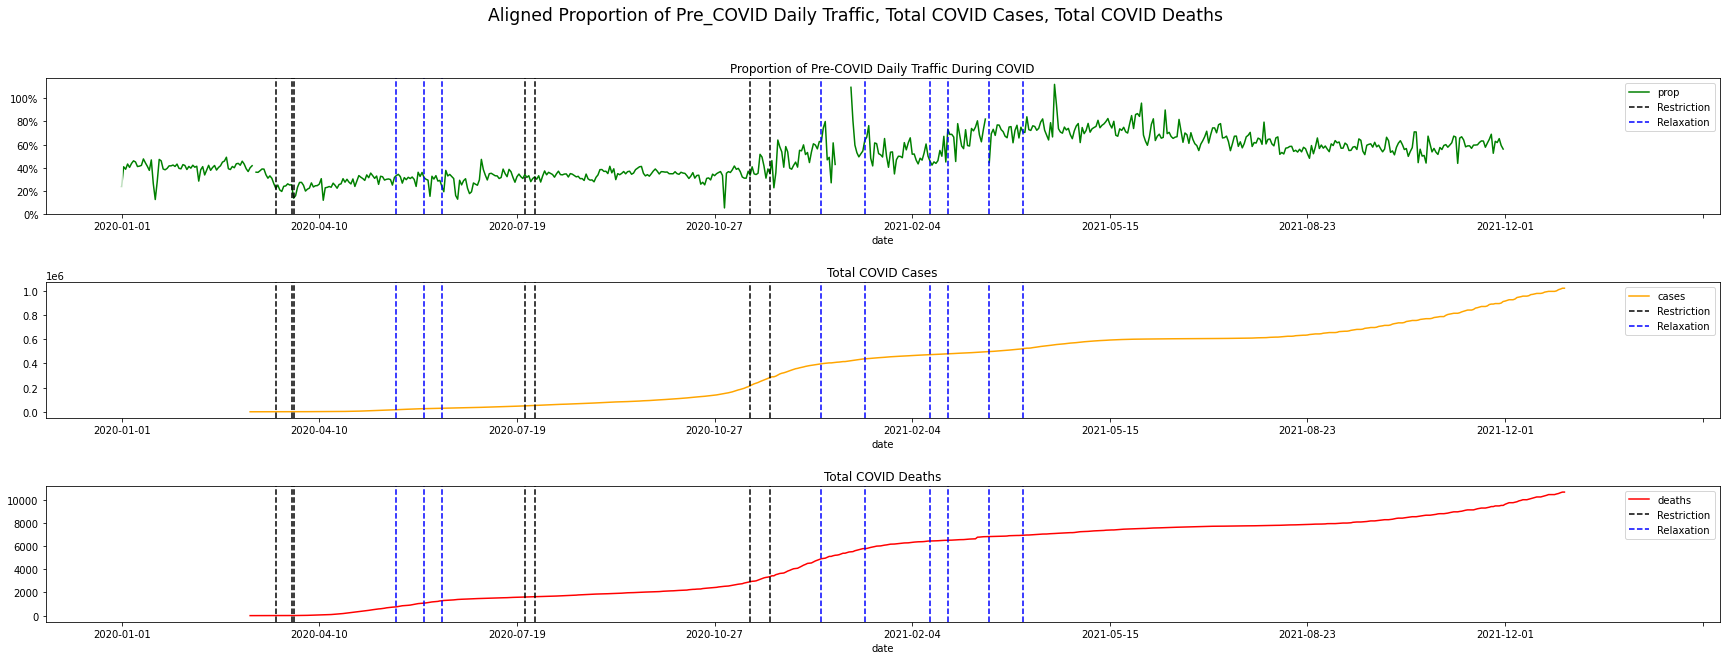

In [0]:
fig, axes = plt.subplots(3,1)
plt.suptitle('Aligned Proportion of Pre COVID Daily Traffic, Total COVID Cases, Total COVID Deaths',fontsize='xx-large')
plt.subplots_adjust(hspace=0.5

plot_df = pre_post_covid_comparison_state.join(daily_cases_deaths,'date',how='outer').filter(F.col('date') < '2022-01-01').toPandas()

plot_df.plot.line(ax=axes[0], x='date',y='prop',color='green')
axes[0].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
axes[0].title.set_text("Proportion of Pre-COVID Daily Traffic During COVID")
plot_df.plot.line(ax=axes[1], x='date',y='cases',color='orange')
axes[1].title.set_text("Total COVID Cases")
plot_df.plot.line(ax=axes[2], x='date',y='deaths',color='red')
axes[2].title.set_text("Total COVID Deaths")

for ax in axes:
    h, l = ax.get_legend_handles_labels()
    
    for date in restriction_series.values:
        rs_label = ax.axvline(date,color='black', label='Restriction', linestyle='--')
    for date in relaxation_series.values:
        rx_label = ax.axvline(date,color='blue', label='Relaxation', linestyle='--')
    for n in [0,770]:
        ax.axvline(n,color='white')
    
    ax.legend(handles=h + [rs_label,rx_label])
plt.show()

## Analysis of Plots
The plot above represents the timeline of major COVID policy events along with the traffic volume, total COVID cases, and total COVID deaths for dates between January 1st 2020 and January 1st 2022. The first set of policy restrictions indicated by dashed vertical black lines are the closures of schools on March 18th, closure of public businesses on March 23rd, and stay-at-home order on March 27th. A sharp drop in traffic volume appears immediately following those measures. It is interesting that the traffic volume was lower in 2020 before COVID cases reached Minnesota and restrictions were in place.

Following the first dropoff and initial restrictions, traffic volume makes a steady climb until a series of relaxations with many businesses allowed to operate at 50% capacity. Surprisingly, the traffic volume actually decreases a bit following these changes. This may be due to the higher than usual indulgene in outdoor activities by Minnesotans following a long winter of being locked in. It is also interesting that the number of total cases and deaths was steadily rising during this first period of relaxation. 

Next, in July of 2020 public schools closed again and the state mask mandate went into effect. No changes were made to business capacity, and only a slight decrease in traffic volume below the Pre-COVID average was seen. 

Fall of 2020 saw an acceleration of COVID case and death counts, which prompted new restrictions. Private gatherings were limited by household and indoor entertainment venues like bars, restaurants, and gyms were closed. Following these restrictions the rate of increase in total COVID cases slowed, but the traffic volume across the state increased rapidly with a peak near pre-pandemic levels. It isn't clear from the data why this happened, but it may indicate that this second round of major restrictions was not as effective as the first in getting Minnesotans to change their behavior to stop the spread of the virus.

Once the infection rate plateaued near the end of 2020, businesses began to reopen at partial capacity and traffic volume increased again. On February 13th, 2021 the maximum capacity of restaurants and other indoor venues was increased to 250, and on February 22nd, 2021 students were allowed back at school in-person. Following these changes the traffic volume increased rapidly to a plateau around 80% where it more or less remained throughout the remaining relaxations on capacity.

## Conclusions
Qualitatively at least, the changes in COVID cases and deaths before restrictions went into effect seem to make sense. The changes at the end of 2020 seem like they did not have as much effect on people's behavior as traffic volume continued to increase after those changes. The late 2020 restrictions do seem to reduce the rate of transmission as the COVID cases graph has an inflection point near the new restrictions on private gatherings and indoor dining. This might mean that people were still gathering in small groups and driving to do so, but not interacting with as many people in public. More data about __where__ people were spending time specifically and if they were with other people might be able to fill in the gaps here. 

Relaxations in general don't seem to be tied as closely to changes in COVID case and death counts. In fact the first relaxation in June of 2020 is close to an inflection point in the death counts graph which means the policy was in place before the rate of increase in deaths had begun to slow. The second series of relaxations came after the infection rate more-or-less plateaued in December. Following the relaxations the infection rate did not increase significantly. It makes sense that there would not be any major decreases in infection and death rate following relaxations, and the fact that there are not significant increases in infection and death rate signal that the relaxations were safe to implement.

# Modeling
We will try using a time-series prediction model to graph the expected traffic volume proportion relative to pre-pandemic volume following COVID policy restrictions. With this goal in mind, there are 4 different time periods that can be used as training and testing scenarios (2 in November):
1. March 2020: Schools closed March 18th, businesses closed March 23rd, and a stay-at-home order went into effect March 27th
2. July 2020: The statewide mask mandate went into effect on July 25th
3. November 2020: 
    * Private gatherings and bar/restaurant capacity were limited on November 13th
    * On November 23rd all indoor dining halted along with the closure of indoor entertainment venues like gyms and theaters

For each, a time-series prediction model will be trained with the 30 days before the policy change to predict the 10 days after the policy change. 

A baseline test will be established by finding the average traffic volume across the years 2017 and 2018, computing the relative proportion of traffic for each day in the year 2019, and selecting 4 random days throughout the year with the 30 days before as training data and 10 days after them as test windows. This test will show the model's ability to predict a time series without major events causing changes in the values. 

Both scenarios will be evaluated with simple Root Mean Squared Error of the predicted traffic volume proportion for all 40 test points compared to the actual traffic volume proportion.

In [0]:
pre_2019_state = wim_iso_daily_state.filter(F.col("year") < 2019) \
                                      .groupBy("week","weekday") \
                                      .agg(F.mean("totalVolume").alias("Pre-COVID Average"))
pre_post_2019_comparison_state = wim_iso_daily_state.filter(F.col("year") == 2019).join(pre_2019_state,["week","weekday"],"left") \
                                                     .withColumn("prop",F.col("totalVolume") / F.col("Pre-COVID Average")) \
                                                     .select("date","totalVolume","Pre-COVID Average","prop")
pre_post_2019_comparison_state.limit(10).show()

+----------+-----------+-----------------+-------------------+
|      date|totalVolume|Pre-COVID Average|               prop|
+----------+-----------+-----------------+-------------------+
|2019-08-23|     851141|        2598892.0| 0.3275014890961225|
|2019-08-22|     781921|        2546278.0|  0.307083908355647|
|2019-08-08|     742763|        2542674.5|0.29211879066707125|
|2019-08-31|     654566|        2051196.5| 0.3191142340580242|
|2019-09-29|     548622|        1821411.0| 0.3012071410571255|
|2019-04-25|     962722|        2387030.0| 0.4033137413438457|
|2019-04-08|     797106|        2176884.0|0.36616833970023205|
|2019-01-17|     923105|        2230491.0|0.41385730765109563|
|2019-04-26|    1048242|        2560287.0| 0.4094236310226158|
|2019-01-24|     834831|        2200408.5| 0.3793981890180846|
+----------+-----------+-----------------+-------------------+



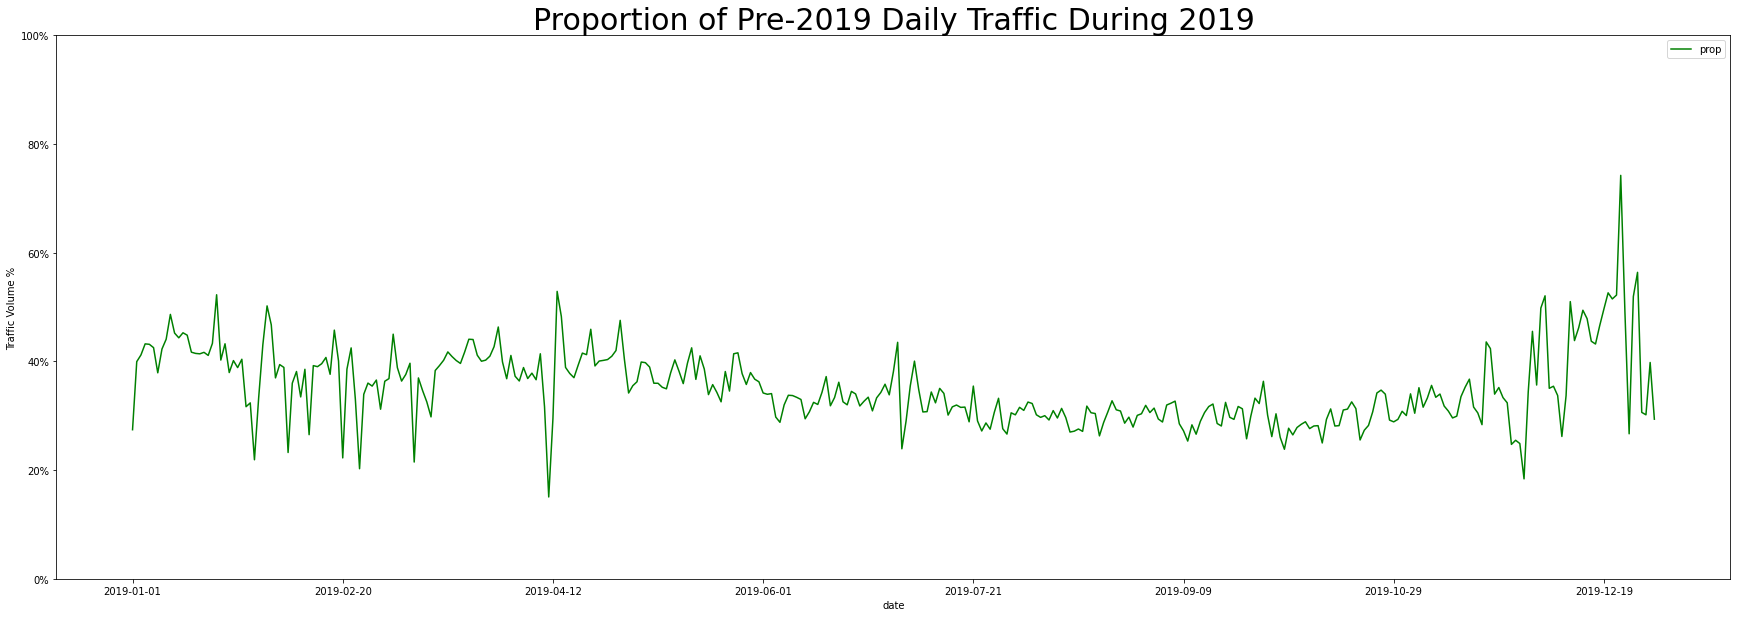

In [0]:
for_plot_state = pre_post_2019_comparison_state.toPandas()
for_plot_state = for_plot_state.sort_values("date")

ax = for_plot_state.plot.line(x='date',y='prop',color='green') 
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.title(label="Proportion of Pre-2019 Daily Traffic During 2019",fontsize=30)
plt.ylabel("Traffic Volume %")
plt.ylim(0,1)
plt.show()

Out[19]: <matplotlib.legend.Legend at 0x7f9e0832f8b0>

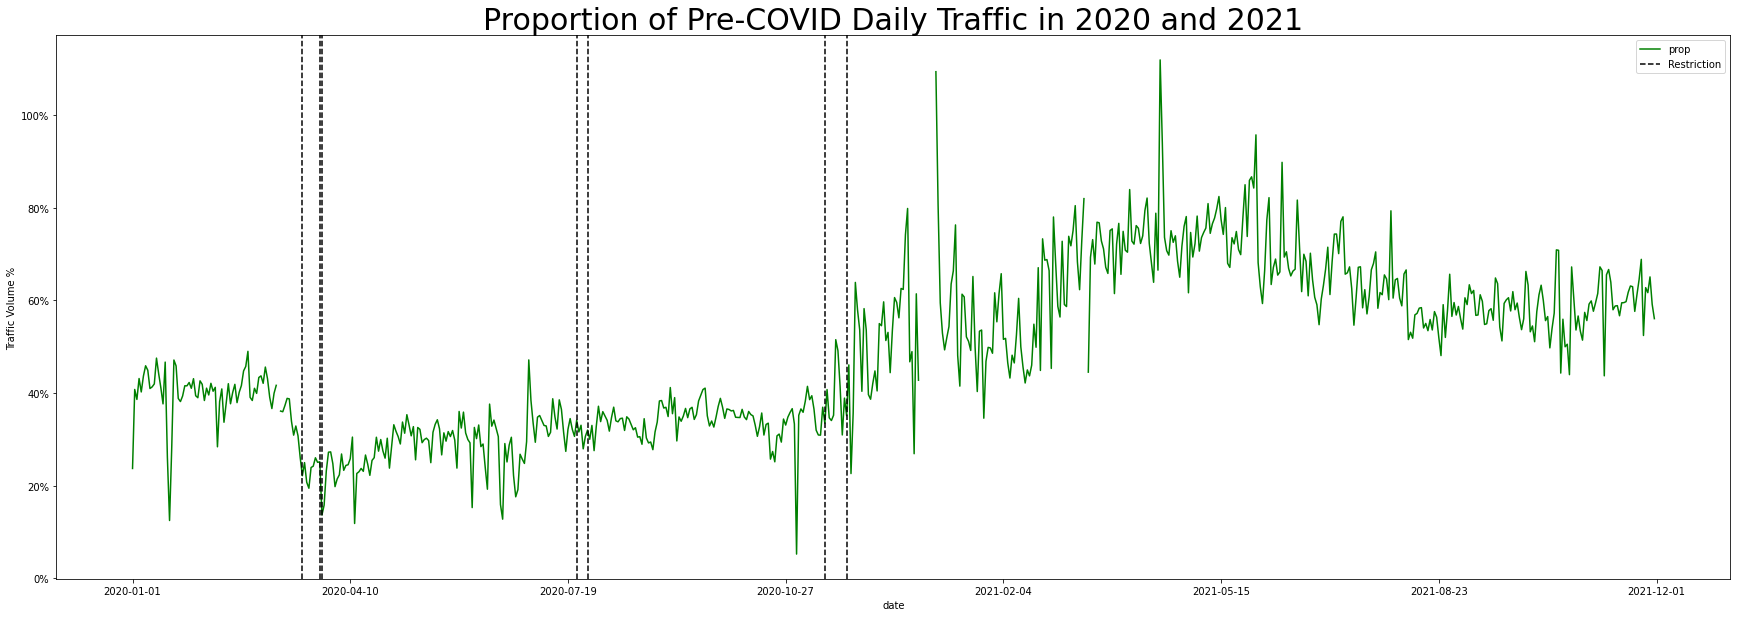

In [0]:
ax = plot_df.plot.line(x='date',y='prop',color='green')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.title(label="Proportion of Pre-COVID Daily Traffic in 2020 and 2021",fontsize=30)
plt.ylabel("Traffic Volume %")

h, l = ax.get_legend_handles_labels()
for date in restriction_series.values:
    rs_label = ax.axvline(date,color='black', label='Restriction', linestyle='--')
    
ax.legend(handles=h + [rs_label])

In [0]:
covid_forecast_data = plot_df.loc[:,['date','prop']]
base_forecast_data = for_plot_state.loc[:,['date','prop']]

covid_test_dates = ['2020-03-18','2020-07-25','2020-11-13','2020-11-23']
base_test_dates = base_forecast_date[(base_forecast_date['date'] < '2019-11-20') & (base_forecast_date['date'] > '2019-02-10')]['date'].sample(4).tolist()

print(covid_test_dates)
print(base_test_dates)

['2020-03-18', '2020-07-25', '2020-11-13', '2020-11-23']
['2019-10-16', '2019-04-04', '2019-06-26', '2019-03-19']


### Create baseline 2019 test sets and COVID-19 test sets from 2020 and 2021

In [0]:
TRAIN_LENGTH = 30
TEST_LENGTH = 10

covid_sets = {}
for date in covid_test_dates:
    train = covid_forecast_data[covid_forecast_data['date'] <= date].tail(TRAIN_LENGTH).rename(columns={'prop':'y'})
    train.loc[:,'ds'] = pd.to_datetime(train['date'])
    test = covid_forecast_data[covid_forecast_data['date'] > date].head(TEST_LENGTH).rename(columns={'prop':'y'})
    test.loc[:,'ds'] = pd.to_datetime(test['date'])
    covid_sets[date] = {'train':train,
                        'test':test}
    
base_sets = {}
for date in base_test_dates:
    train = base_forecast_data[base_forecast_data['date'] <= date].tail(TRAIN_LENGTH).rename(columns={'prop':'y'})
    train.loc[:,'ds'] = pd.to_datetime(train['date'])
    test = base_forecast_data[base_forecast_data['date'] > date].head(TEST_LENGTH).rename(columns={'prop':'y'})
    test.loc[:,'ds'] = pd.to_datetime(test['date'])
    base_sets[date] = {'train':train,
                        'test':test}

### Fit a Facebook Prophet model to each baseline 2019 test

INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.


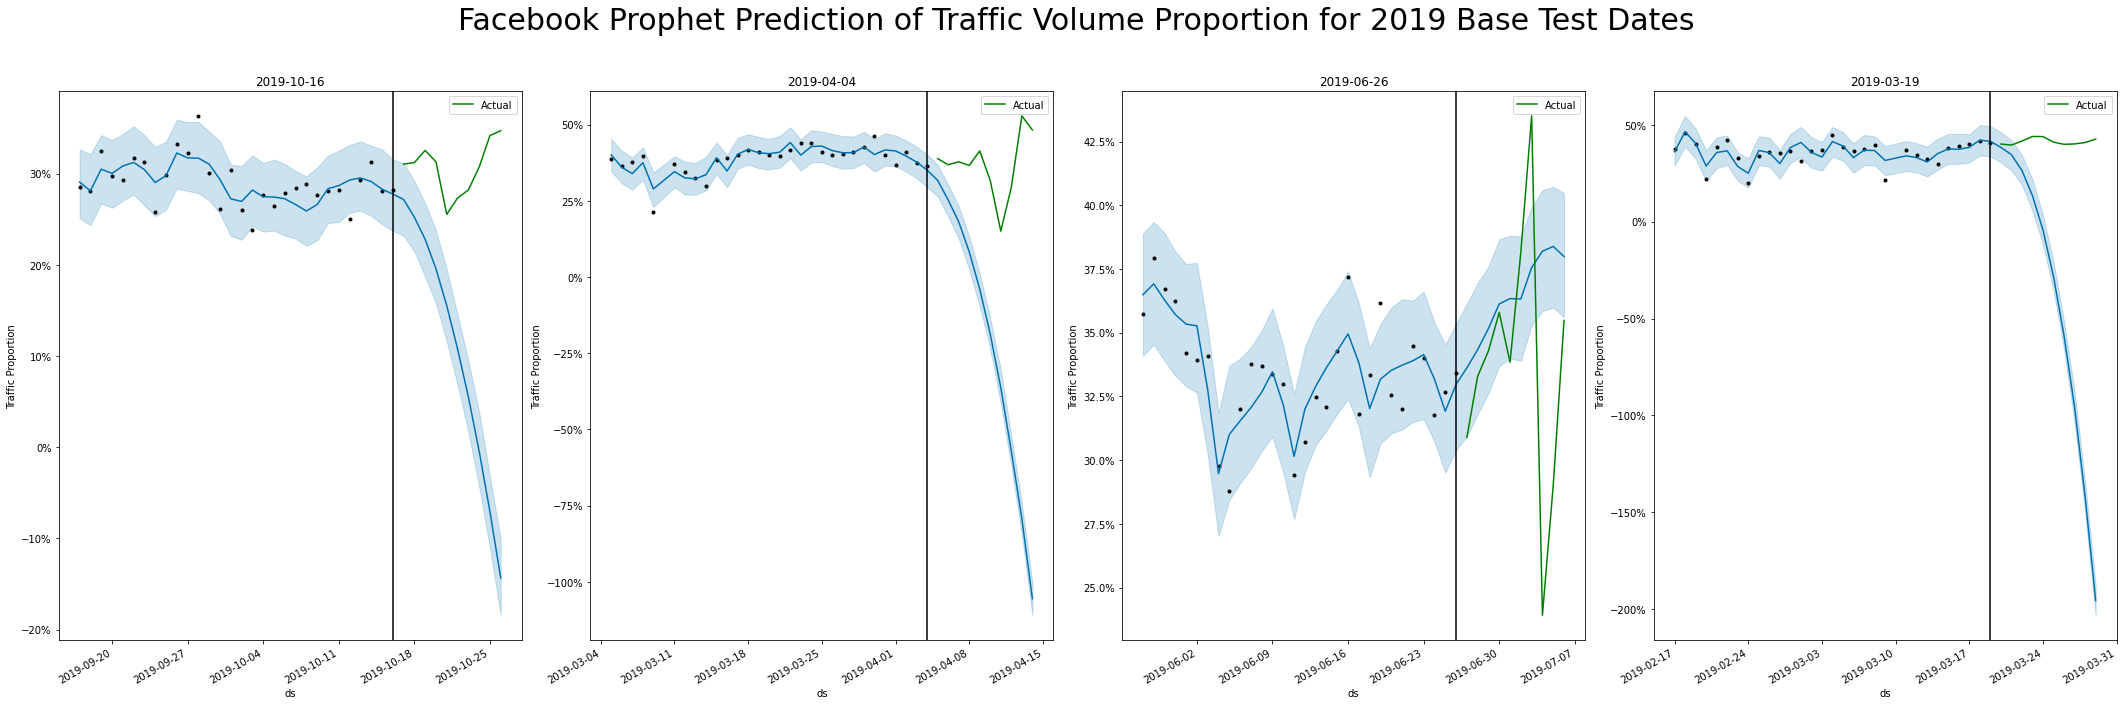

In [0]:
# fit the model to historical data
fig,axes = plt.subplots(1,4)
index=0
for date in base_sets:
    # instantiate the model and set parameters
    model = Prophet(
        interval_width=0.95,
        growth='linear',
        daily_seasonality=False,
        weekly_seasonality=True,
        yearly_seasonality=True,
        seasonality_mode='multiplicative'
    )

    history_pd = base_sets[date]['train']
    model.fit(history_pd)
    
    future_pd = model.make_future_dataframe(
        periods=10,
        freq='d',
        include_history=True
    )

    # predict over the dataset
    forecast_pd = model.predict(future_pd)
    
    predict_fig = model.plot(forecast_pd, xlabel='date', ylabel='Traffic Proportion',ax=axes[index])
    base_sets[date]['test'].plot.line(ax=axes[index],x='ds',y='y', color='green',label='Actual')
    axes[index].axvline(forecast_pd.iloc[TRAIN_LENGTH-1]['ds'],color='black')
    axes[index].title.set_text(str(date))
    axes[index].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    
    base_sets[date]['model'] = forecast_pd
    index += 1

plt.suptitle("Facebook Prophet Prediction of Traffic Volume Proportion for 2019 Base Test Dates",fontsize=30,y=1.08)
plt.subplots_adjust(hspace=0.5)
plt.show()

### Fit a Facebook Prophet model to each major COVID 19 restriction event

INFO:fbprophet:n_changepoints greater than number of observations. Using 22.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.


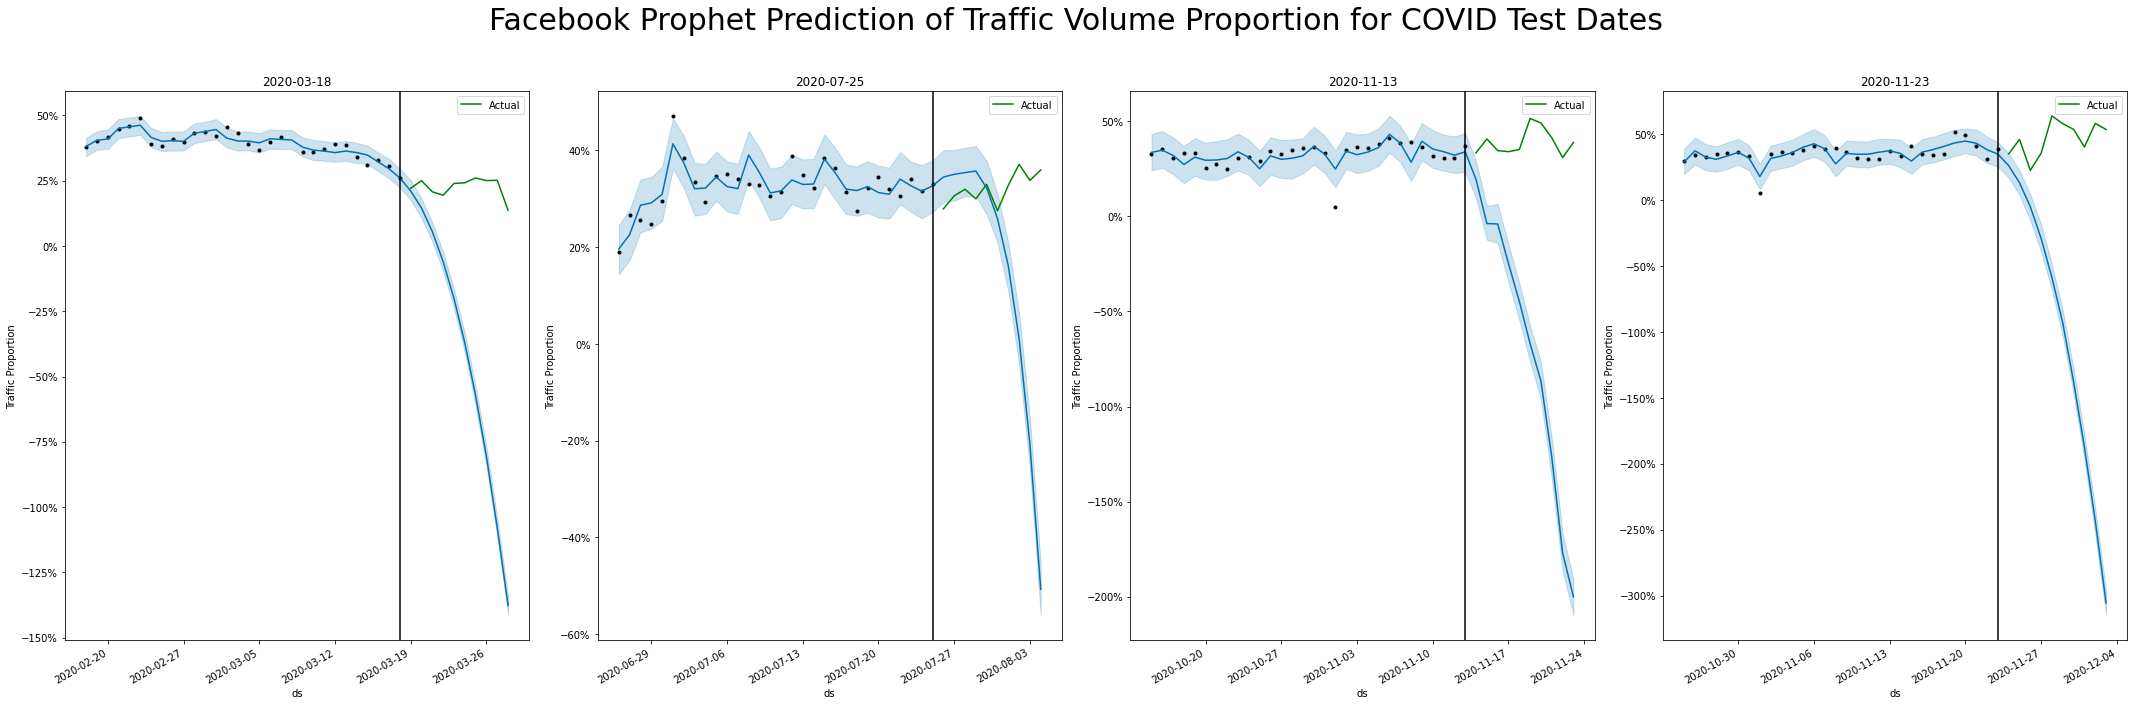

In [0]:
fig,axes = plt.subplots(1,4)
index=0
for date in covid_sets:
    # instantiate the model and set parameters
    model = Prophet(
        interval_width=0.95,
        growth='linear',
        daily_seasonality=False,
        weekly_seasonality=True,
        yearly_seasonality=True,
        seasonality_mode='multiplicative'
    )

    history_pd = covid_sets[date]['train']
    model.fit(history_pd)
    
    future_pd = model.make_future_dataframe(
        periods=10,
        freq='d',
        include_history=True
    )

    # predict over the dataset
    forecast_pd = model.predict(future_pd)
    
    predict_fig = model.plot(forecast_pd, xlabel='date', ylabel='Traffic Proportion',ax=axes[index])
    axes[index].axvline(forecast_pd.iloc[TRAIN_LENGTH-1]['ds'],color='black')
    covid_sets[date]['test'].plot.line(ax=axes[index],x='ds',y='y', color='green',label='Actual')
    axes[index].title.set_text(str(date))
    axes[index].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    
    covid_sets[date]['model'] = forecast_pd
    index += 1

plt.suptitle("Facebook Prophet Prediction of Traffic Volume Proportion for COVID Test Dates",fontsize=30,y=1.08)    
plt.show()

### Calculate train and test RMSE for each sample

#### Baseline

In [0]:
base_out = {}
for date in base_sets:
    date_set = base_sets[date]
    
    base_out[date] = []
    for s in ['train','test']:
        tmp = pd.merge(date_set[s],date_set['model'][['ds','yhat']],how='left')
        tmp['diff'] = (tmp['yhat'] - tmp['y']) ** 2
        rmse = (tmp['diff'].mean()) ** 0.5
        date_set[s+'_rmse'] = rmse
        base_out[date].append(rmse)

In [0]:
base_tests = pd.DataFrame.from_dict(base_out, columns=['train_rmse','test_rmse'],orient='index')
print(base_tests)
print()
print('Average Train RMSE:',base_tests['train_rmse'].mean())
print('Average Test RMSE:',base_tests['test_rmse'].mean())

            train_rmse  test_rmse
2019-10-16    0.019980   0.249948
2019-04-04    0.026919   0.756229
2019-06-26    0.012664   0.059368
2019-03-19    0.039418   1.127075

Average Train RMSE: 0.024745229394833243
Average Test RMSE: 0.5481550936573452


#### COVID

In [0]:
covid_out = {}
for date in covid_sets:
    date_set = covid_sets[date]
    
    covid_out[date] = []
    for s in ['train','test']:
        tmp = pd.merge(date_set[s],date_set['model'][['ds','yhat']],how='left')
        tmp['diff'] = (tmp['yhat'] - tmp['y']) ** 2
        rmse = (tmp['diff'].mean()) ** 0.5
        date_set[s+'_rmse'] = rmse
        covid_out[date].append(rmse)

In [0]:
covid_tests = pd.DataFrame.from_dict(covid_out, columns=['train_rmse','test_rmse'],orient='index')
print(covid_tests)
print()
print('Average Train RMSE:',covid_tests['train_rmse'].mean())
print('Average Test RMSE:',covid_tests['test_rmse'].mean())

            train_rmse  test_rmse
2020-03-18    0.018858   0.808842
2020-07-25    0.027070   0.349142
2020-11-13    0.049890   1.321108
2020-11-23    0.050118   1.877342

Average Train RMSE: 0.03648380780603501
Average Test RMSE: 1.0891085991999927


### Conclusions
The Facebook Prophet time series prediction did not work very well at all for this traffic data even after adjusting the expected traffic volume by weekday. The algorithm is meant to be well-suited for data that has strong seasonal trends and several seasons worth of input data. A better solution would be one that allows for specific dates to be marked as events and learn from what happens before and after those events. Unfortunately the Prophet model can only be trained on a single series for input, so using separate groups of dates before and after COVID policy changes is not possible.

The models fit to baseline data in 2019 and the COVID year models both diverged from the training data quickly, confirming that the short period of input data is not adequate for training an effective model. Other tools would need to be used in future pandemic sitautions that are capable of learning from several short time series in order to make forecasts in the future based on highly irregular events.